In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import montecarlo_localization as mcl
#%load_ext autoreload     -syntax not recognised
#%autoreload 2            -syntax not recognised
##%matplotlib inline      -syntax not recognised
plt.style.use('ggplot')

# Development Notes

## Method for extracting particles by weight

In [154]:
a = np.array([p for p in range(10)])
a

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

/\ works

In [155]:
b = a / a.sum()
b

array([ 0.        ,  0.02222222,  0.04444444,  0.06666667,  0.08888889,
        0.11111111,  0.13333333,  0.15555556,  0.17777778,  0.2       ])

/\works

In [156]:
choices = np.random.multinomial(len(a), b)
choices

array([0, 0, 0, 0, 1, 2, 0, 0, 4, 3])

/\works

In [157]:
new_particle_list = []
for idx, count in enumerate(choices):
    while count > 0:
        new_particle_list.append(copy.copy(a[idx]))
        count -= 1
new_particle_list

[4, 5, 5, 8, 8, 8, 8, 9, 9, 9]

/\works

above implemented in `montecarlo_localization.mcl_update()`

# Unit Tests:

## Load and plot Wean Hall map

Test implementation

In [158]:
global_map = mcl.occupancy_map('data/map/wean.dat.gz')
mcl.draw_map_state(global_map, rotate=True)

/\FileNotFoundError: [Errno 2] No such file or directory: './data/range_array_120bin.npy'

duplicate version of mcl.occupancy_map() function made, called mcl.values_only_occupancy_map(), that doesn't try to read precomputed range values:

In [ ]:
global_map = mcl.values_only_occupancy_map('data/map/wean.dat.gz')
mcl.draw_map_state(global_map, rotate=True)
mcl.plt.show()

/\works

## mcl.sample_list_by_weight()

In [159]:
toy_list = [l for l in 'abcd']
weights  = [10,5,1,0.1]

sample_list = [mcl.sample_list_by_weight(toy_list, weights) 
               for _ in range(100)]
print(sample_list[:10])
df = pd.DataFrame(sample_list)
print("\nValue Counts in first location:")
print(df[0].value_counts())

[['a', 'c', 'd', 'b'], ['b', 'a', 'a', 'a'], ['a', 'a', 'a', 'b'], ['a', 'a', 'a', 'a'], ['a', 'b', 'b', 'a'], ['a', 'a', 'a', 'b'], ['b', 'a', 'a', 'a'], ['b', 'a', 'b', 'b'], ['a', 'a', 'a', 'a'], ['b', 'a', 'a', 'b']]

Value Counts in first location:
a    61
b    31
c     8
Name: 0, dtype: int64


/\ AttributeError: 'str' object has no attribute 'new_pose_from_sample_error'


In [ ]:
toy_list = [l for l in 'abcd']
weights  = [10,5,1,0.1]

sample_list = [mcl.sample_list_by_weight(toy_list, weights, perturb=False)) 
               for _ in range(100)]
print(sample_list[:10])
df = pd.DataFrame(sample_list)
print("\nValue Counts in first location:")
print(df[0].value_counts())

/\works

## mcl.robot_particle.sample_motion()

In [162]:
global_map = mcl.occupancy_map('data/map/wean.dat.gz')
logdata = mcl.load_log('data/log/robotdata1.log.gz')
logdata.head()

type        ts          x           y     theta         xl          yl  \
0     1  0.025466 -94.234001 -139.953995 -1.342158 -88.567719 -164.303391   
1     0  0.025863 -94.234001 -139.953995 -1.342158        NaN         NaN   
2     0  0.079745 -94.234001 -139.953995 -1.342158        NaN         NaN   
3     0  0.139828 -94.234001 -139.953995 -1.342158        NaN         NaN   
4     0  0.200218 -94.234001 -139.953995 -1.342158        NaN         NaN   

     thetal   1   2 ...   171  172  173  174  175  176  177  178  179  180  
0 -1.342158  66  66 ...    71   71   71   71   71   71   70   70   70   70  
1       NaN NaN NaN ...   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2       NaN NaN NaN ...   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
3       NaN NaN NaN ...   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
4       NaN NaN NaN ...   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  

[5 rows x 188 columns]

/\ FileNotFoundError: [Errno 2] No such file or directory: './data/range_array_120bin.npy'

in mcl.load_log(),  full_log = pd.concat([scans, odometry]) changed to  full_log = pd.concat([scans, odometry], sort=False)
robotdata1.log.gz should be 181kb, not 614kb (which is probably not gzipped)

In [ ]:
global_map = mcl.values_only_occupancy_map('data/map/wean.dat.gz')
logdata = mcl.load_log('data/log/robotdata1.log.gz')
print(logdata.head())

/\works

In [163]:
import time
fig, ax = plt.subplots(figsize=(10,10))
mcl.draw_map_state(global_map, ax=ax)
for _ in range(3):
    sensor = mcl.laser_sensor()
    particle = mcl.robot_particle(global_map, sensor)
    locations = np.array([particle.sample_motion(msg)
                          for msg in logdata.values])
    location_subset = locations[::50]
    for pose in location_subset[:, 0:4]:
        mcl.plot_particle(pose, ax, pass_pose=True)
plt.show()

in `mcl.robot_particle.position_valid()`:
changed `nearest_xindex = self.pose[0]//10`       and  `nearest_yindex = self.pose[1]//10`
to:     `nearest_xindex = int(self.pose[0]//10)`  and  `nearest_yindex = int(self.pose[1]//10)`

and changed above code to:

In [ ]:
import time
fig, ax = mcl.plt.subplots(figsize=(10,10))
mcl.draw_map_state(global_map, ax=ax)
for _ in range(3):
    sensor = mcl.laser_sensor()
    particle = mcl.robot_particle(global_map, sensor)
    locations = np.array([particle.sample_motion(msg)
                          for msg in logdata.values])
    location_subset = locations[::50]
    for pose in location_subset[:, 0:4]:
        mcl.plot_particle(pose, ax, pass_pose=True)
mcl.plt.show()

/\works

## Initialize valid particles uniformly on map

Particles are initialized uniformy over the entire 8000cm x 8000cm area with random heading, but are re-sampled if they end up in a grid cell which is not clear with high confidence (map value > 0.8).

In [164]:
particle_list = [mcl.robot_particle(global_map, sensor)
                 for _ in range(1000)]
mcl.draw_map_state(global_map, particle_list, rotate=True)
plt.show()

/\works

## Animation of moving particle

In [165]:
import matplotlib.animation as animation

sensor = mcl.laser_sensor()
particle = mcl.robot_particle(global_map, sensor)
fig, ax = plt.subplots()

def init():    
    mcl.draw_map_state(global_map, ax=ax)

def animate(message):
    #plt.cla()
    #mcl.draw_map_state(global_map, ax=ax)
    particle.sample_motion(message)
    mcl.plot_particle(particle, ax)

ani = animation.FuncAnimation(fig, animate, logdata.values[::50], init_func=init,
    interval=50, blit=False, repeat=False)

plt.show()

/\works

## Simple raycast in map

In [167]:
theta = 0
global_map = mcl.occupancy_map('data/map/wean.dat.gz')
fig, axes = plt.subplots(ncols=8, figsize=(12,4))
for ax in axes: 
    theta += np.pi/10
    x,y,dist = mcl.raycast_bresenham(2200, 4200, theta, global_map)
    ax = mcl.draw_map_state(global_map, ax=ax)
    ax.set_title("d: " + str(int(dist)) + 'cm')
    ax.set_ylim((4000,4500))
    ax.set_xlim((2000,2500))
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.scatter(2200, 4200, s=100)
    ax.plot([x, 2200],[y,4200], c='r')
    ax.scatter(x,y, s=40, c='r')
plt.show()

c:\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


/\ gives `FileNotFoundError: [Errno 2] No such file or directory: './data/range_array_120bin.npy'`
        changed `occupancy_map()` to `values_only_occupancy_map()`
        ... and seems to work


### Raycasting each of 360 degrees around robot takes ~7.6ms per map location

In [168]:
%%timeit
for theta in np.linspace(0,2*np.pi, num=360):
    x,y,dist = mcl.raycast_bresenham(2200, 4200, theta, global_map)

100 loops, best of 3: 7.34 ms per loop


/\didn't work

In [ ]:
import timeit

def raycast_test():
    for theta in np.linspace(0,2*np.pi, num=360):
        x,y,dist = mcl.raycast_bresenham(2200, 4200, theta, global_map)

print(timeit.timeit(raycast_test, number=1000))

/\ did work, result: ~6.8seconds on my laptop, so ~6.8milliseconds per loop

## Pre-calculate (cache) range values in map

### Due to the static map, these values can be cached ahead of time (instead of re-computing for each particle)

In [179]:
%%time
def cache_map_ranges(theta_bins=120):
    slice_theta_rad = 2*np.pi/theta_bins
    slice_theta_deg = 360/theta_bins
    map_width, map_height = 800, 800

    coord_list = [(xidx, yidx) for yidx in range(map_height) 
                               for xidx in range(map_width)]
    range_array = np.zeros([map_width,map_height,theta_bins])
    raycast_degree_values = np.linspace(0,2*np.pi, num=theta_bins)
    # pre-calculate (cache) expected distance to wall for each theta bin, at each map location
    for xidx,yidx in coord_list:
        for idx, theta in enumerate(raycast_degree_values):
            _,_,dist = mcl.raycast_bresenham(xidx*10, yidx*10, theta, global_map, freespace_min_val=0.7)
            range_array[xidx,yidx,idx] = dist
    
    np.save('./data/range_array_{}bin'.format(theta_bins), range_array, allow_pickle=False)
    return range_array
raw_array = cache_map_ranges(theta_bins=120)  # Takes ~9 minutes with theta_bins=120 on core i5 laptop

Wall time: 9min 35s


/\worked, using values_only_occupancy_map

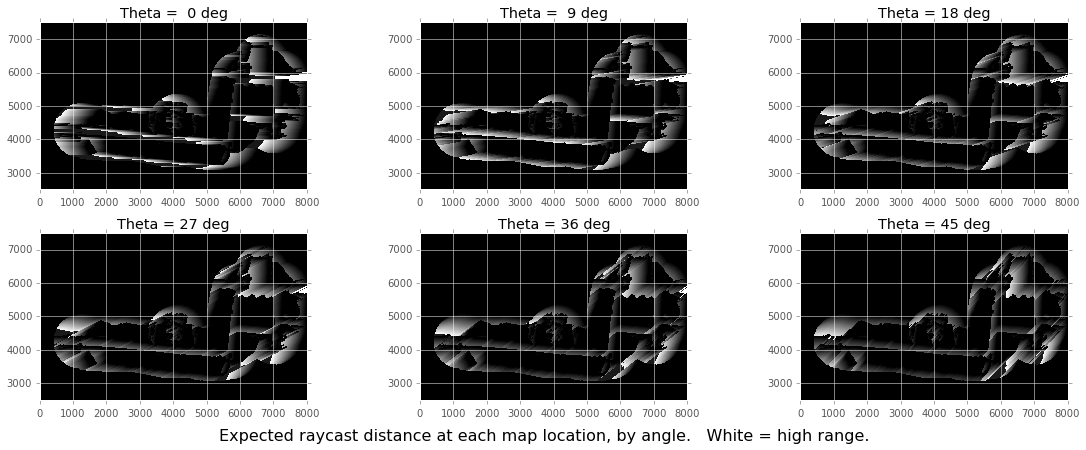

In [182]:
range_array = np.load('./data/range_array_40bin.npy')
slice_theta_deg = 360/40
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(16, 6))
for idx, ax in enumerate(fig.axes):
    ax.imshow(range_array[:,:,idx].T, cmap=plt.cm.gray, interpolation='nearest',
                  origin='lower', extent=(0,8000,0,8000), aspect='equal')
    ax.set_ylim(2500,7500)
    ax.set_xlim(0,8000)
    ax.set_title("Theta = {:2.0f} deg".format(idx*slice_theta_deg))
fig.tight_layout()
fig.suptitle("Expected raycast distance at each map location, by angle.   White = high range.", size=16, y=0)


/\ didn't work. adding `mcl.plt.show()` made the plots show, seem to be correct

## Test particle stochastic movement

### Very low error

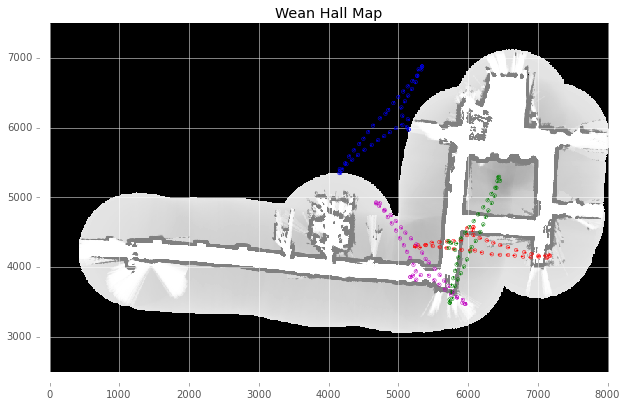

In [89]:
fwd_err_pct, theta_err_pct = 0.01, 0.01
colors = ['r', 'g', 'b', 'm']

fig, ax = plt.subplots(figsize=(10,10))
plt.hold(True)
mcl.draw_map_state(global_map, ax=ax)
for idx in range(4):
    sensor = mcl.laser_sensor()
    particle = mcl.robot_particle(global_map, sensor,
                                  fwd_err_pct, theta_err_pct)
    locations = np.array([particle.sample_motion(msg)
                          for msg in logdata.values])
    location_subset = locations[::50]
    for pose in location_subset[:, 0:4]:
        mcl.plot_particle(pose, ax, pass_pose=True, color=colors[idx])
plt.show()

/\ needed `plt.hold(True)` removing, and `logdata = mcl.load_log('data/log/robotdata1.log.gz')` before starting
then it worked

### Theta error stdv = 10%

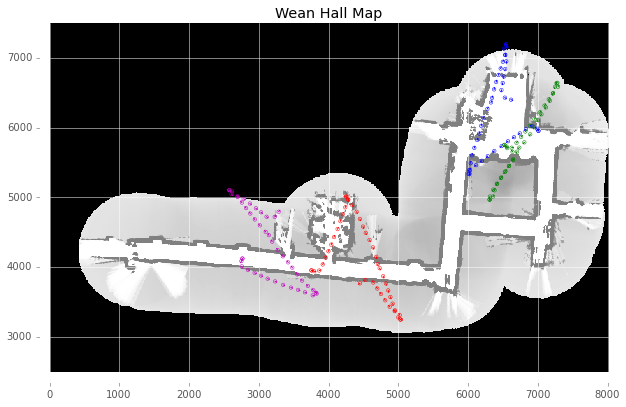

In [90]:
fwd_err_pct, theta_err_pct = 0.01, 0.1
colors = ['r', 'g', 'b', 'm']

fig, ax = plt.subplots(figsize=(10,10))
plt.hold(True)
mcl.draw_map_state(global_map, ax=ax)
for idx in range(4):
    sensor = mcl.laser_sensor()
    particle = mcl.robot_particle(global_map, sensor,
                                  fwd_err_pct, theta_err_pct)
    locations = np.array([particle.sample_motion(msg)
                          for msg in logdata.values])
    location_subset = locations[::50]
    for pose in location_subset[:, 0:4]:
        mcl.plot_particle(pose, ax, pass_pose=True, color=colors[idx])
plt.show()

/\ needed `plt.hold(True)` removing, and `logdata = mcl.load_log('data/log/robotdata1.log.gz')` before starting
then it worked

## Animate several moving particles

In [6]:
import matplotlib.animation as animation

wean_hall_map = mcl.occupancy_map('data/map/wean.dat')
logdata = mcl.load_log('data/log/robotdata1.log.gz')
logdata_scans = logdata.query('type > 0.1')

#Initialize 100 particles uniformly in valid locations on the map
laser = mcl.laser_sensor(stdv_cm=20, uniform_weight=0.2)
particle_list = [mcl.robot_particle(wean_hall_map, laser, log_prob_descale=100,
                                    sigma_fwd_pct=0.3, sigma_theta_pct=0.2)
                 for _ in range(300)]

# Pre-run first couple steps - hard to draw on screen
#for message in logdata_scans.values[:30:10]:
#    particle_list = mcl.mcl_update(particle_list, message, 
#                                    target_particles=300) # Update

class ParticleMap(object):
    def __init__(self, ax, global_map, particle_list):
        self.ax = ax
        self.global_map = global_map
        self.particle_list = particle_list
        mcl.draw_map_state(global_map, particle_list[::50], ax=self.ax)
        self.i = 1

    def update(self, message):
        self.particle_list = mcl.mcl_update(self.particle_list, message, 
                                            target_particles=300) # Update
        if self.i % 20 == 0:# Plot every 10th message
            plt.cla()        
            mcl.draw_map_state(self.global_map, self.particle_list, self.ax)
            #print(self.i, "  ", len(self.particle_list))
            print(pd.Series([p.weight for p in particle_list]).describe())
        self.i += 1

fig, ax = plt.subplots()
pmap = ParticleMap(ax, wean_hall_map, particle_list)

# pass a generator in "emitter" to produce data for the update func
ani = animation.FuncAnimation(fig, pmap.update, logdata_scans.values, interval=50,
                              blit=False, repeat=False)
plt.show()

20    925
count    3.000000e+04
mean     1.324679e-02
std      1.694024e-02
min      2.497719e-09
25%      5.407322e-05
50%      1.065434e-03
75%      2.798312e-02
max      1.238952e-01
dtype: float64
40    311
count    3.000000e+04
mean     1.324679e-02
std      1.694024e-02
min      2.497719e-09
25%      5.407322e-05
50%      1.065434e-03
75%      2.798312e-02
max      1.238952e-01
dtype: float64
60    300
count    3.000000e+04
mean     1.324679e-02
std      1.694024e-02
min      2.497719e-09
25%      5.407322e-05
50%      1.065434e-03
75%      2.798312e-02
max      1.238952e-01
dtype: float64
80    300
count    3.000000e+04
mean     1.324679e-02
std      1.694024e-02
min      2.497719e-09
25%      5.407322e-05
50%      1.065434e-03
75%      2.798312e-02
max      1.238952e-01
dtype: float64
100    300
count    3.000000e+04
mean     1.324679e-02
std      1.694024e-02
min      2.497719e-09
25%      5.407322e-05
50%      1.065434e-03
75%      2.798312e-02
max      1.238952e-01
dtype: fl

/\ works after changing  `def ranges_180()` to start with `x_loc = int(min(x_cm//10, 799))  y_loc = int(min(y_cm//10, 799))`

In [22]:
np.concatenate([[1,2],[2,3]])

array([1, 2, 2, 3])

In [3]:
%%prun
wean_hall_map = mcl.occupancy_map('data/map/wean.dat')
logdata = mcl.load_log('data/log/robotdata1.log.gz')

#Initialize 100 particles uniformly in valid locations on the map
laser = mcl.laser_sensor(stdv_cm=100, uniform_weight=0.3)
particle_list = [mcl.robot_particle(wean_hall_map, laser, log_prob_descale=70,
                                    sigma_fwd_pct=0.1, sigma_theta_pct=0.1)
                 for _ in range(10000)]
for message in logdata.values[:100]:
    particle_list = mcl.mcl_update(particle_list, message)

In [24]:
mcl.draw_map_state(wean_hall_map, particle_list)
plt.show()

/\ works, (with `%%prun` removed) except I don't think they're uniformly positioned. sometimes seems to get stuck, takes a random time to run. but often around 7seconds.

## Re-weight per sensor model

c:\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


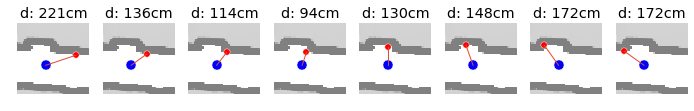

In [35]:
%matplotlib inline
theta = 0
global_map = mcl.occupancy_map('data/map/wean.dat.gz')
fig, axes = plt.subplots(ncols=8, figsize=(12,4))
for ax in axes: 
    theta += np.pi/10
    x,y,dist = mcl.raycast_bresenham(2200, 4200, theta, global_map)
    ax = mcl.draw_map_state(global_map, ax=ax)
    ax.set_title("d: " + str(int(dist)) + 'cm')
    ax.set_ylim((4000,4500))
    ax.set_xlim((2000,2500))
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.scatter(2200, 4200, s=100)
    ax.plot([x, 2200],[y,4200], c='r')
    ax.scatter(x,y, s=40, c='r')
plt.show()

/\ works, (with `%matplotlib inline` removed)

### View likelihood of two similar measurements

In [36]:
wean_hall_map = mcl.occupancy_map('data/map/wean.dat')
logdata = mcl.load_log('data/log/robotdata1.log.gz')
laser = mcl.laser_sensor(stdv_cm=100, uniform_weight=0.1)
particle = mcl.robot_particle(wean_hall_map, laser, sigma_fwd_pct=0.4, sigma_theta_pct=0.1)
range_array_120 = np.load('./data/range_array_120bin.npy')
logdata = mcl.load_log('data/log/robotdata1.log.gz')

In [37]:
rng_far = (logdata.values[0,8:188:3])
rng1 = particle.global_map.ranges_180(2200, 4200, 2*np.pi/40)
rng2 = particle.global_map.ranges_180(2200, 4200, 0)


/\ runs but no output

### Measurement probabilities of poor match match

In [38]:
sample_probs_exact_match = laser.measurement_probabilities(rng2, rng2)
sample_probs_poor_match = laser.measurement_probabilities(rng_far, rng2)
print("Dist Error: ", rng_far - rng2)
print("Probabilities: ",sample_probs_poor_match)

Dist Error:  [  -74.35668848   -74.35668848   -75.42135624   -77.17821063   -89.24174696
   -91.11388301   -94.55494421   -98.52945357   -97.52945357  -103.
   325.72243623   294.98924762   252.90627288   203.50566759   152.72583002
   108.04902432    87.81487828    71.97058983    43.55589796     7.15290347
   -73.21422387  -119.18546143  -211.96356141  -323.83275543  -544.43501271
  -908.86022959 -1923.17275369 -3216.72700079  -979.97423484  -609.          -677.
  -451.70273919  -170.89721644  -164.10561809  -112.94117082    12.38490029
    65.103799      87.86792084   100.11705772   125.           150.35662478
   169.77794898   188.98529491   211.93751525   251.58405421   -21.13708499
   -17.30145813   -14.           -17.           -27.16653826   -23.95630141
   -21.48857802   -22.48857802   -20.86832981   -21.86832981   -32.40306509
   -62.41664064   -60.52946438   -59.3840481    -60.3840481 ]
Probabilities:  [  1.25000000e-05   1.25000000e-05   1.25000000e-05   1.25000000e-05
   1.

/\works

### Measurement probabilities of good match match

In [39]:
sample_probs_good_match = laser.measurement_probabilities(rng1, rng2)
print("\nDist Error: ", rng1 - rng2)
print("Probabilities: ",sample_probs_good_match)


Dist Error:  [  2.82152216e+00   1.48850585e+01   1.66925268e+01   1.83767336e+01
   1.02877066e+01   7.41557056e+00   8.44505579e+00   1.47481102e+01
   2.04812988e+01   2.20937271e+01   1.82167686e+01   4.02634176e+01
   6.28572486e+01   7.16907893e+01   4.57552402e+01   3.34931264e+01
   4.36619748e+01   9.91848137e+01   1.18741359e+02   1.80116465e+02
   2.29618532e+02   4.10249551e+02   6.82896668e+02   1.58734000e+03
   2.66229199e+03   6.51140052e+01  -1.31817275e+03  -2.60972700e+03
  -6.01271496e+02  -4.37102784e+02  -5.14894382e+02  -3.34761568e+02
  -1.73282117e+02  -1.43209417e+02  -1.12809092e+02  -7.17321574e+01
  -4.18962010e+01  -4.04887039e+01  -4.36608913e+01  -3.39852949e+01
  -2.45808905e+01  -2.38061052e+01  -2.28776201e+01  -2.17610266e+01
  -2.04159458e+01  -1.31370850e+01   1.86508014e+00   2.95630141e+00
  -1.51142198e+00  -9.67796025e+00  -8.08797160e+00  -3.62024821e+00
   5.91448707e+00   3.85483108e+01   3.66611346e+01   2.59809830e+01
  -3.03259254e+00  -

/\works

## Full probabilities of a complete scan (perfect, good, poor)

In [41]:
laser.full_scan_log_prob(sample_probs_exact_match)

0.0

In [42]:
laser.full_scan_log_prob(sample_probs_good_match)

-269.16528146389032

In [43]:
laser.full_scan_log_prob(sample_probs_poor_match)

-402.36610332642528

In [44]:
rng = 10
perfect_match_probs = laser.measurement_probabilities(np.array(list(range(rng))), np.array(list(range(rng))))
scaling_factor = 1/perfect_match_probs[0]
scaling_factor

27.841732374568785

/\all four work

array([ 0.04570777,  0.00318848,  0.00157496,  0.00076577,  0.01346549])

## Control rate of particle depletion

In [24]:
%matplotlib inline
wean_hall_map = mcl.occupancy_map('data/map/wean.dat')
logdata = mcl.load_log('data/log/robotdata1.log.gz')

#Initialize 100 particles uniformly in valid locations on the map
laser = mcl.laser_sensor(stdv_cm=20, uniform_weight=0.2)
particle_list = [mcl.robot_particle(wean_hall_map, laser, log_prob_descale=50,
                                    sigma_fwd_pct=0.3, sigma_theta_pct=0.2)
                 for _ in range(30000)]
scan_data_gen = (msg for msg in logdata.query('type > 0.1').values)


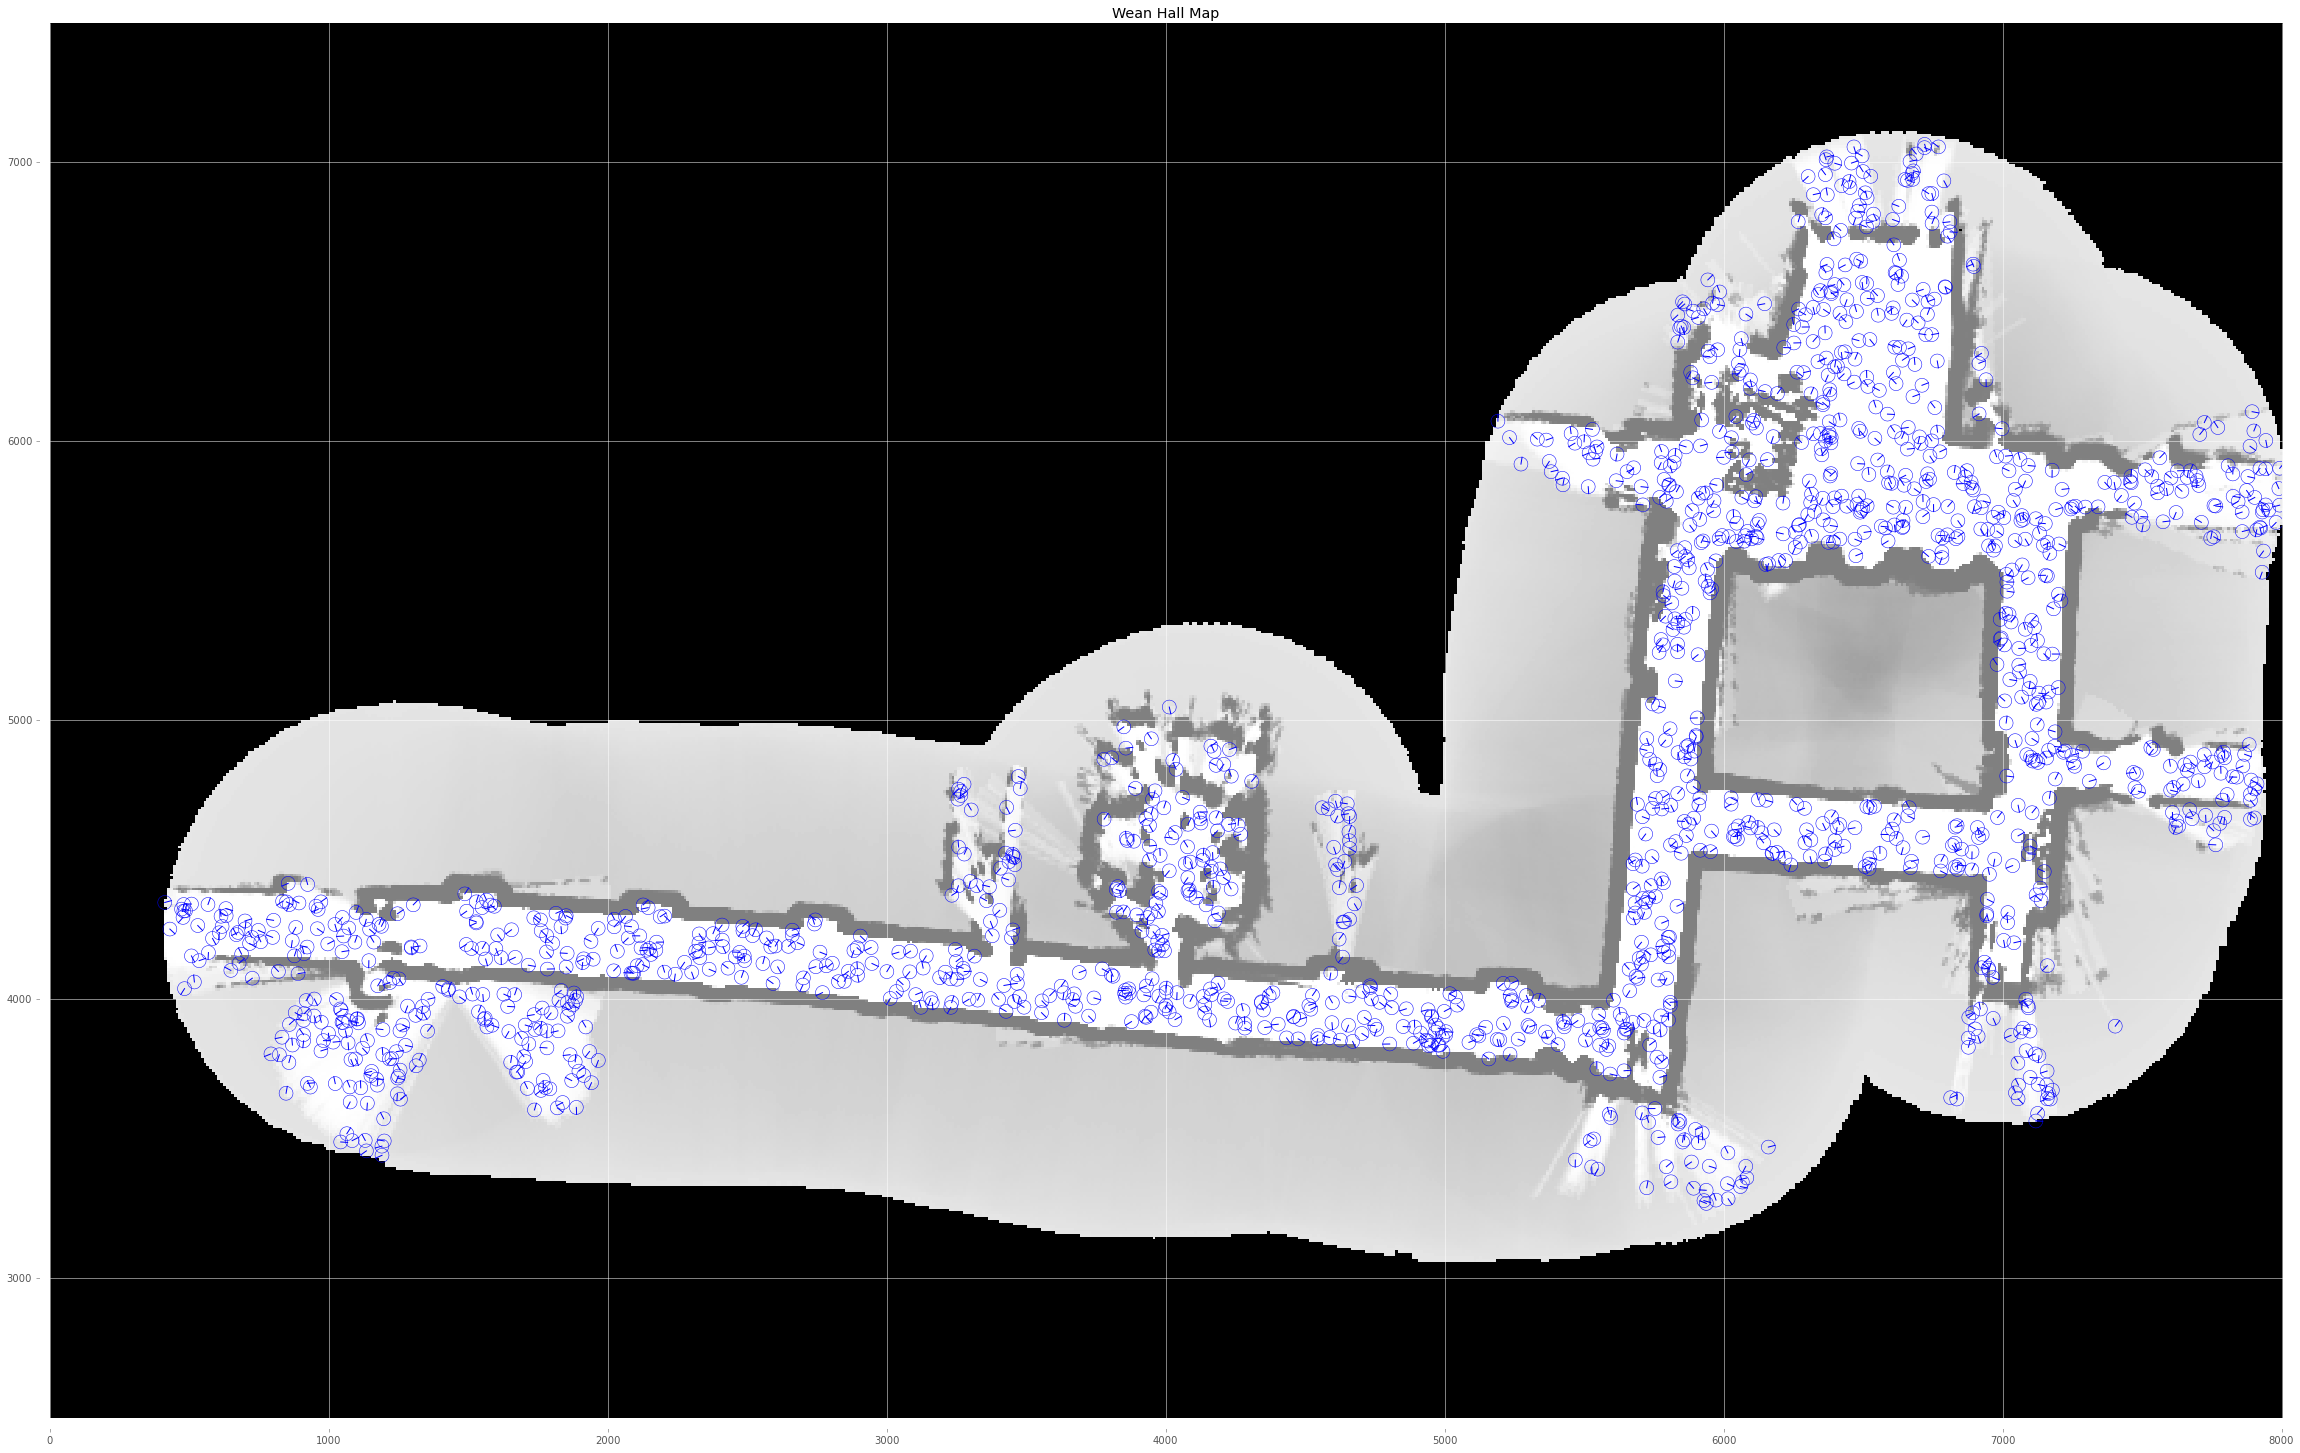

In [25]:
fig, ax = plt.subplots(figsize=(40,40))
mcl.draw_map_state(wean_hall_map, particle_list[::20], ax=ax)

/\added `plt.show()` and it worked

In [26]:
new_particle_list = mcl.mcl_update(particle_list, next(scan_data_gen))

In [27]:
weights = pd.Series([p.weight for p in new_particle_list])
weights.describe()

count    27131.000000
mean         0.000189
std          0.000193
min          0.000071
25%          0.000084
50%          0.000124
75%          0.000220
max          0.006939
dtype: float64

/\ works (after wrapping a `print()` around `weights.describe()`)

In [28]:
new_particle_list = mcl.mcl_update(new_particle_list, next(scan_data_gen))

In [29]:
weights = pd.Series([p.weight for p in new_particle_list])
weights.describe()

count    16422.000000
mean         0.000126
std          0.000511
min          0.000003
25%          0.000022
50%          0.000058
75%          0.000130
max          0.030840
dtype: float64

/\works, same comment as above

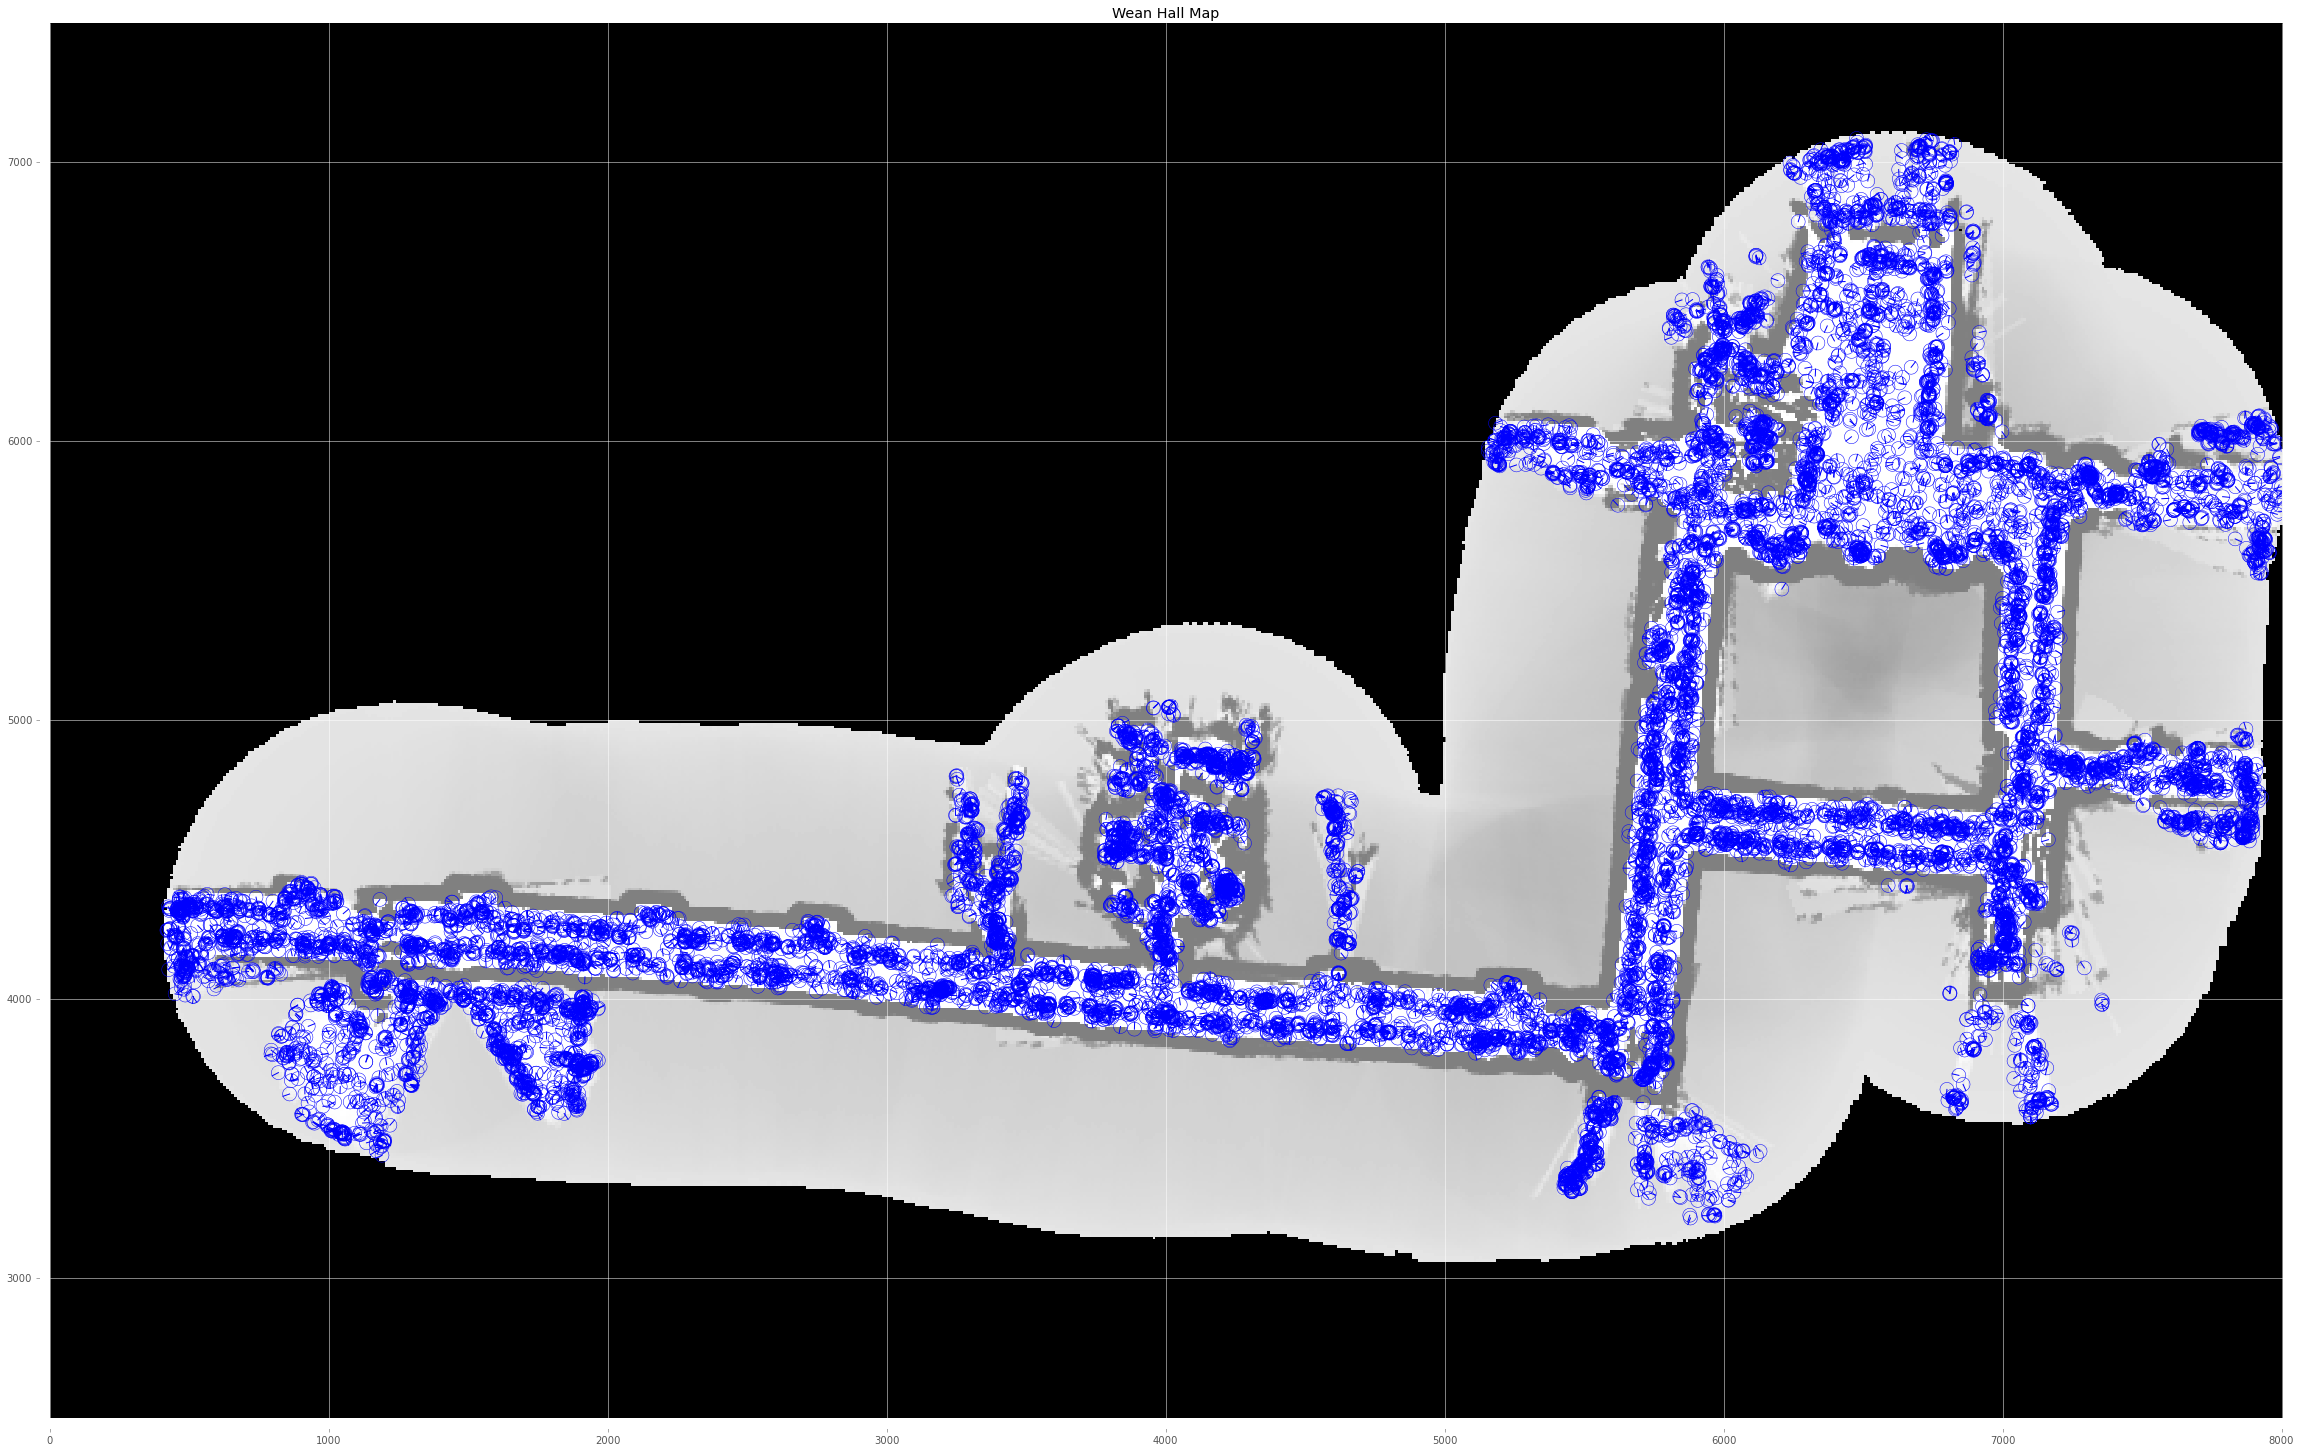

In [30]:
fig, ax = plt.subplots(figsize=(40,40))
mcl.draw_map_state(wean_hall_map, new_particle_list, ax=ax)

/\ works with `plt.show()` at the end

In [31]:
new_particle_list = mcl.mcl_update(new_particle_list, next(scan_data_gen))

In [32]:
pd.Series([p.weight for p in new_particle_list]).describe()

count    6.985000e+03
mean     3.432880e-04
std      3.318940e-03
min      1.538964e-07
25%      3.471401e-05
50%      8.884922e-05
75%      2.022310e-04
max      1.417625e-01
dtype: float64

/\works

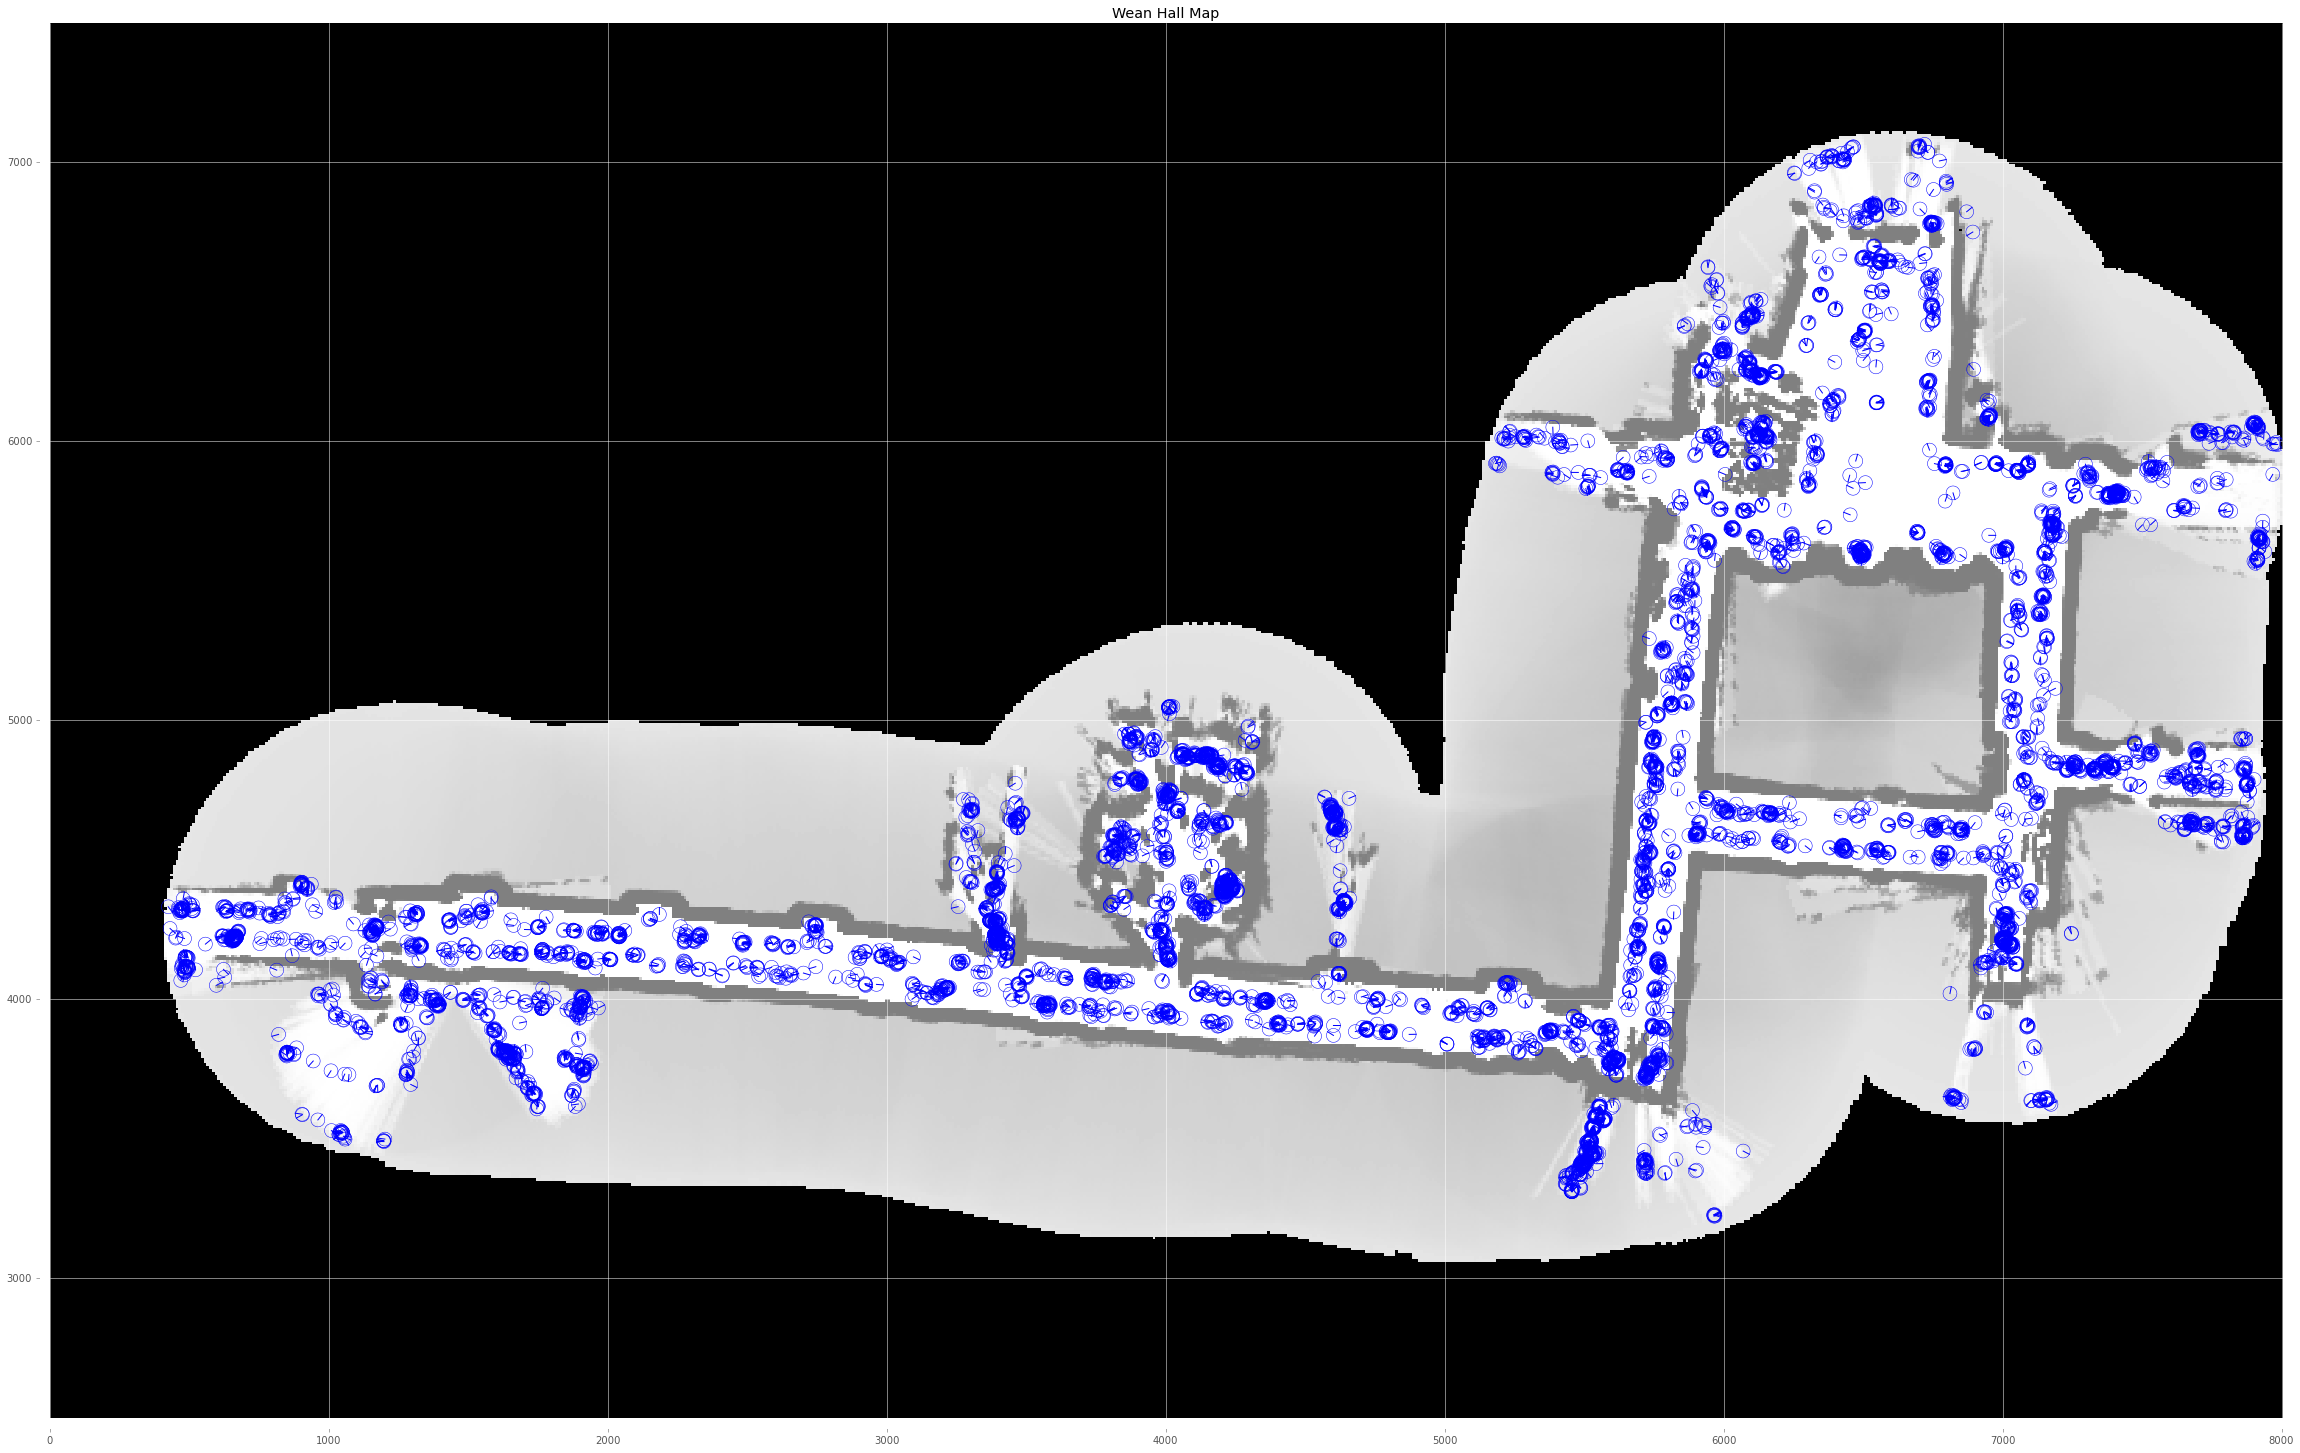

In [33]:
fig, ax = plt.subplots(figsize=(40,40))
mcl.draw_map_state(wean_hall_map, new_particle_list, ax=ax)

In [ ]:
/\works

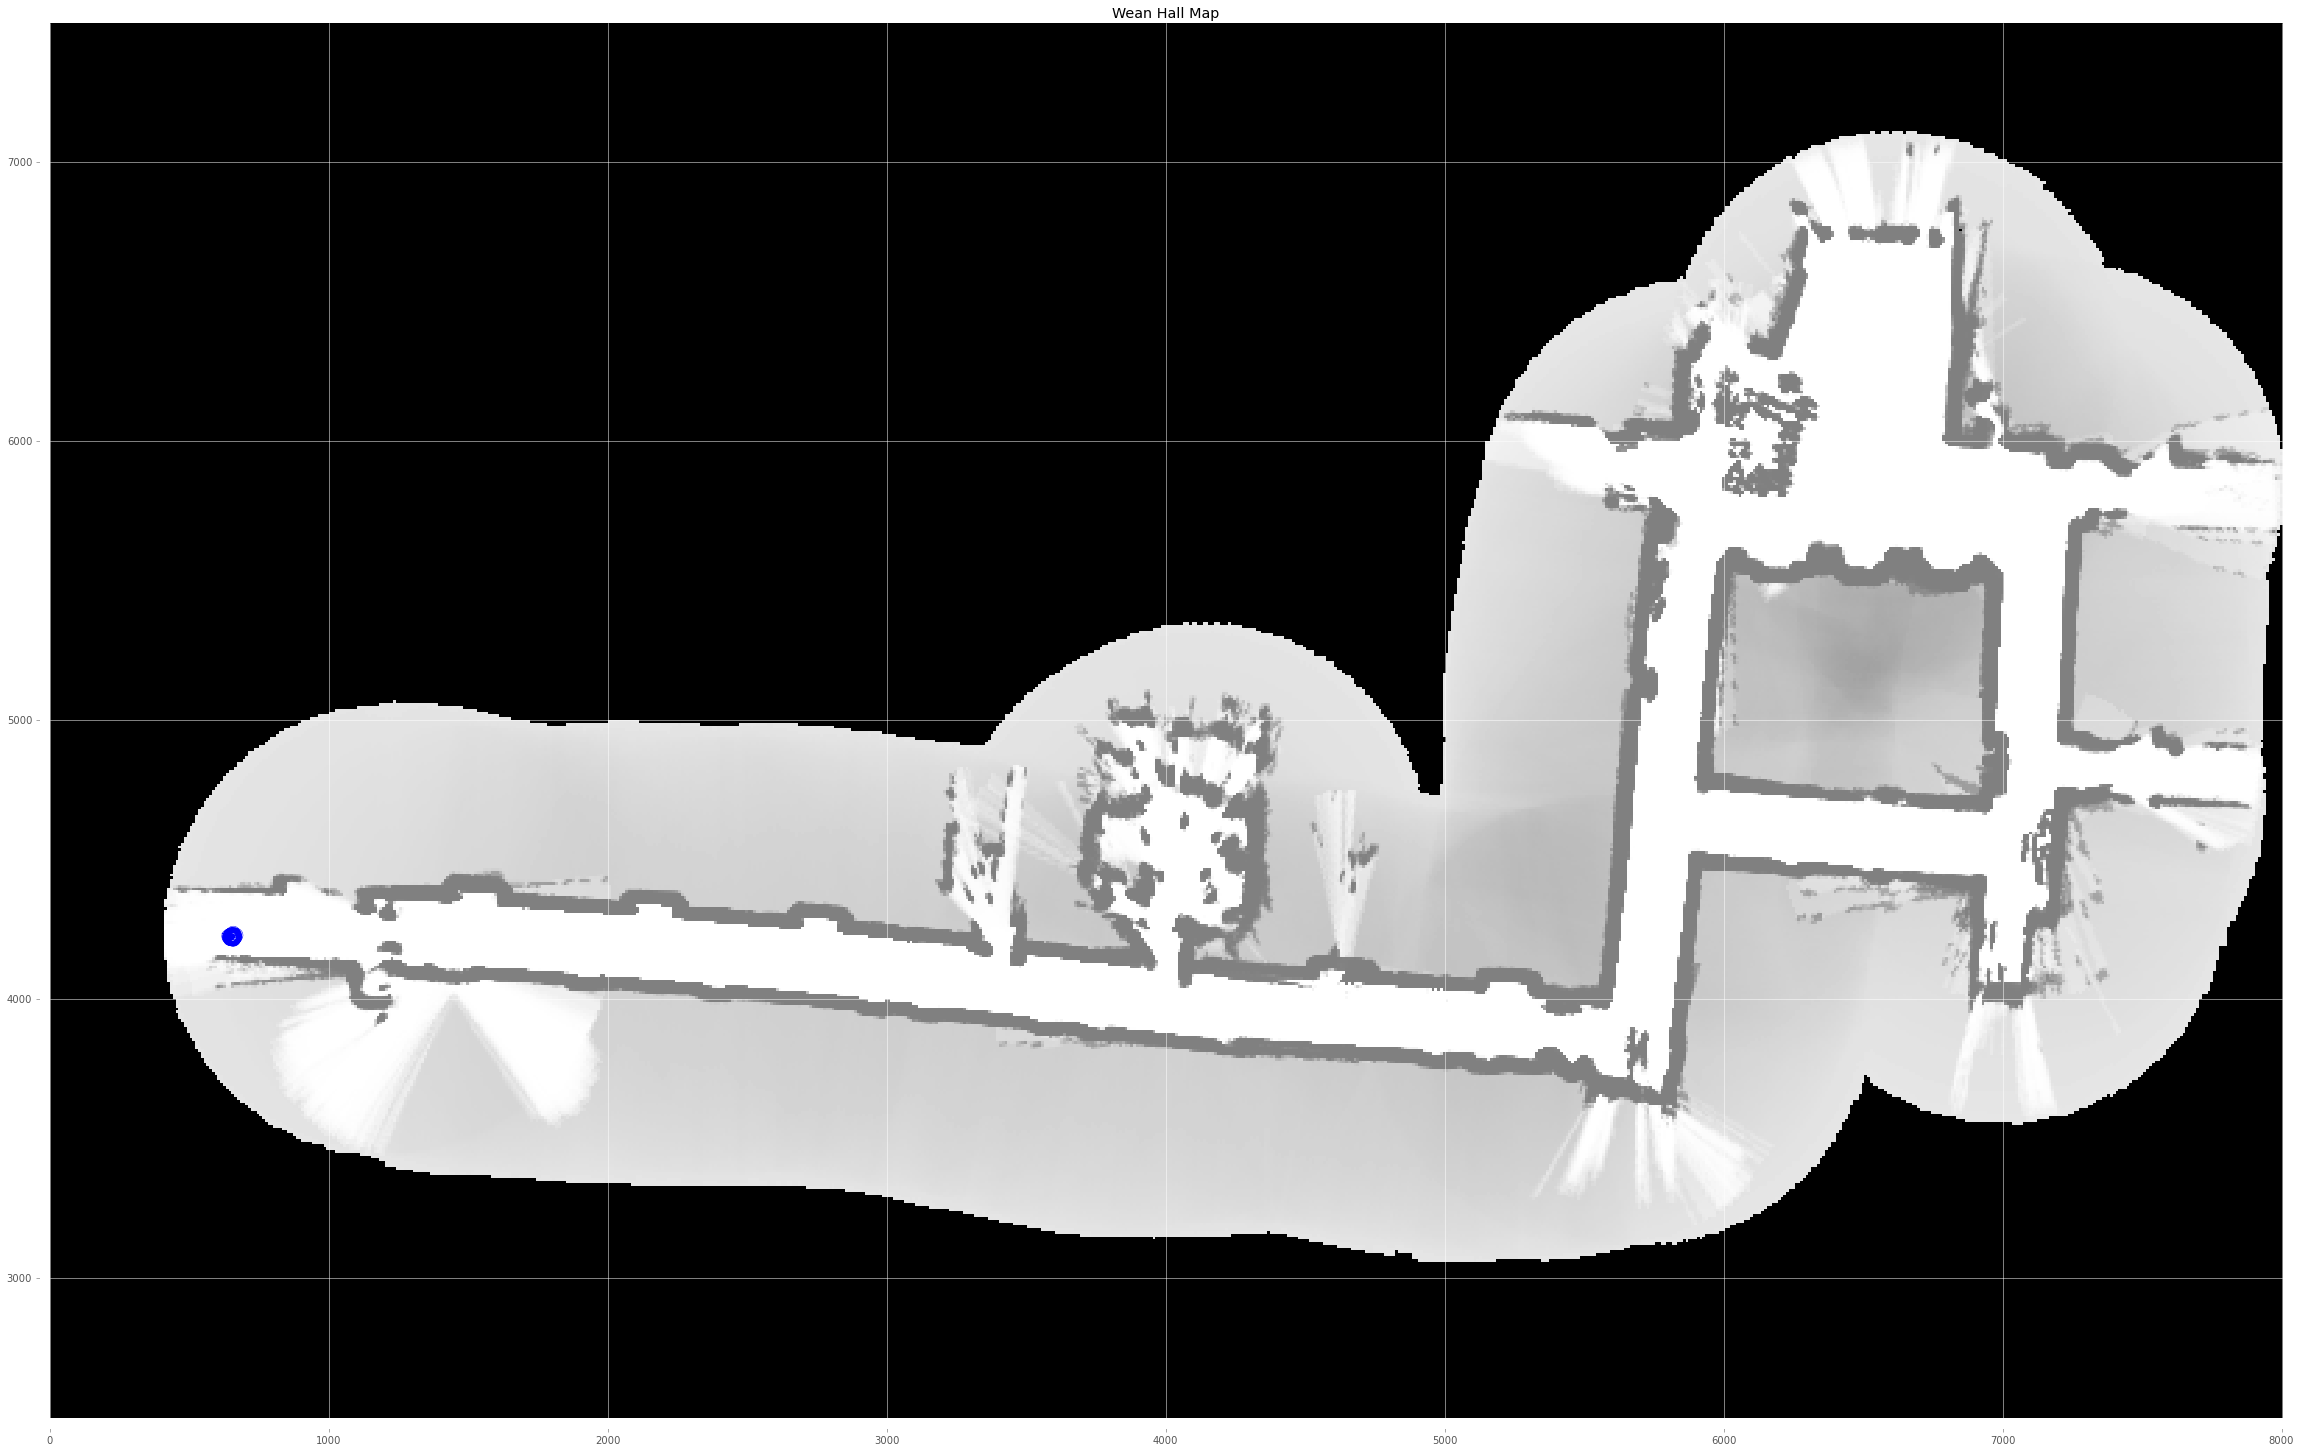

In [34]:
for _ in range(20):
    new_particle_list = mcl.mcl_update(new_particle_list, next(scan_data_gen))
fig, ax = plt.subplots(figsize=(40,40))
mcl.draw_map_state(wean_hall_map, new_particle_list, ax=ax)

/\works

In [65]:
len(new_particle_list)

300

/\works

In [ ]:
new_particle_list

In [276]:
p = mcl.robot_particle(wean_hall_map, laser)
print(p.pose)

[  6.58390449e+03   6.01333879e+03   4.06236805e+00]


/\works

In [300]:
p.new_pose_from_sample_error()
print(p.pose[0])
print(p.pose[1])
p.pose[2]

6598.08194782
6003.75199296


4.358746777868638

/\worked once, failed once. numbers different but similar

In [ ]:

new_particle_list = mcl.mcl_update(new_particle_list, next(scan_data_gen))

In [403]:
particle_list[0].

In [ ]:
/\works

In [414]:
for p in new_particle_list:
    print(p.pose)

[  1.56937407e+03   4.37230654e+03  -1.65914312e+00]
[  5.53365050e+03   3.53610856e+03  -1.68081983e+00]
[  5.53365050e+03   3.53610856e+03  -1.68081983e+00]
[  5.53365050e+03   3.53610856e+03  -1.68081983e+00]
[  5.53365050e+03   3.53610856e+03  -1.68081983e+00]
[  5.53365050e+03   3.53610856e+03  -1.68081983e+00]
[  5.53365050e+03   3.53610856e+03  -1.68081983e+00]
[  5.53365050e+03   3.53610856e+03  -1.68081983e+00]
[  5.53365050e+03   3.53610856e+03  -1.68081983e+00]
[  5.53365050e+03   3.53610856e+03  -1.68081983e+00]
[  1.56937407e+03   4.37230654e+03  -1.65914312e+00]
[  5.53365050e+03   3.53610856e+03  -1.68081983e+00]
[  5.53365050e+03   3.53610856e+03  -1.68081983e+00]
[  5.53365050e+03   3.53610856e+03  -1.68081983e+00]
[  5.53365050e+03   3.53610856e+03  -1.68081983e+00]
[  5.53365050e+03   3.53610856e+03  -1.68081983e+00]
[  5.53365050e+03   3.53610856e+03  -1.68081983e+00]
[  5.53365050e+03   3.53610856e+03  -1.68081983e+00]
[  1.56937407e+03   4.37230654e+03  -1.6591431

/\works

In [370]:
max([p.weight for p in particle_list])

0.00010000000000000662

/\runs, though the returned value was different

In [371]:
len([p.weight for p in particle_list])

10000

/\runs, value 30,000 though, as you'd expect from the code above...

type        ts          x           y     theta         xl          yl  \
0      1  0.025466 -94.234001 -139.953995 -1.342158 -88.567719 -164.303391   
5      1  0.204230 -94.234001 -139.953995 -1.342158 -88.567719 -164.303391   
9      1  0.394368 -94.234001 -139.953995 -1.342158 -88.567719 -164.303391   
13     1  0.584142 -94.234001 -139.953995 -1.342158 -88.567719 -164.303391   
17     1  0.784171 -94.234001 -139.953995 -1.342158 -88.567719 -164.303391   

      thetal   1   2 ...   171  172  173  174  175  176  177  178  179  180  
0  -1.342158  66  66 ...    71   71   71   71   71   71   70   70   70   70  
5  -1.342158  66  66 ...    71   71   71   71   70   70   70   70   70   70  
9  -1.342158  66  66 ...    71   71   70   70   70   70   71   70   70   70  
13 -1.342158  66  66 ...    71   71   70   71   70   71   70   70   70   70  
17 -1.342158  66  66 ...    71   71   71   71   70   71   70   70   70   70  

[5 rows x 188 columns]

In [334]:
%%prun
wean_hall_map = mcl.occupancy_map('data/map/wean.dat')
logdata = mcl.load_log('data/log/robotdata1.log.gz')
laser = mcl.laser_sensor(stdv_cm=100, uniform_weight=0.4)
particle_list = [mcl.robot_particle(wean_hall_map, laser, 
                 sigma_fwd_pct=0.4, sigma_theta_pct=0.1)
                 for _ in range(10000)]
for message in logdata.values:
    particle_list = mcl.mcl_update(particle_list, message)

AttributeError: 'robot_particle' object has no attribute 'sensor'

```
 135105098 function calls (135103848 primitive calls) in 415.633 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   905268  179.985    0.000  179.985    0.000 montecarlo_localization.py:85(<listcomp>)
 54316080   59.674    0.000   59.674    0.000 montecarlo_localization.py:89(rads_to_bucket_id)
  2718627   26.278    0.000   32.328    0.000 montecarlo_localization.py:165(new_pose_from_log_delta)
   905268   26.027    0.000  352.293    0.000 montecarlo_localization.py:136(update_measurement_likelihood)
   905268   18.846    0.000   78.519    0.000 montecarlo_localization.py:99(<listcomp>)
9188368/9188365   13.292    0.000   13.292    0.000 {built-in method numpy.core.multiarray.array}
  2849599   11.917    0.000   11.917    0.000 montecarlo_localization.py:192(position_valid)
  1810536   10.112    0.000   15.713    0.000 blas.py:221(_get_funcs)
```

In [ ]:
mcl.draw_map_state(wean_hall_map, particle_list)
plt.show()